## LockSense Image Classification

#### Model Selection: Transfer Learning

- Rationale: Insufficient data to train a full model from scratch
- Considerations: Need to find a lightweight model to (hypothetically) allow edge inference

Links/References:
- [All Keras models](https://keras.io/api/applications/)
- Keras documentation: [Transfer Learning](https://keras.io/guides/transfer_learning/)

Models to consider:
- Lightweight
    - MobileNetV2
    - NASNetMobile
    - DenseNet121
- Others
    - InceptionV3

### Utility functions and constants

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history, plot_name):
    # Visualize history
    # Plot history: Loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('%s (Loss)' % plot_name)
    plt.ylabel('Loss value')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Plot history: Accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('%s (Accuracy)' % plot_name)
    plt.ylabel('Accuracy value (%)')
    plt.xlabel('No. epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()


In [ ]:
num_classes = 3

input_shape=(224, 224, 3)
target_size=(224, 224)

batch_size = 16

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def create_augmented_dataset(path):
    # Include data augmentation techniques
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=(0.5, 1.5),
		rotation_range=10,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True
    )
    # Ensure shape matches the required input shape
    train_generator = train_datagen.flow_from_directory(
        path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical',
        # save_to_dir="augmented_images/"
    )

    return train_generator


def create_dataset(path):
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_directory(
        path,
        target_size=target_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    return generator

### Hyperparameter Tuning

Documentation:
- [Keras Tuner Tutorial](https://www.tensorflow.org/tutorials/keras/keras_tuner)
- [Tuner class](https://keras.io/api/keras_tuner/tuners/)

In [ ]:
import keras_tuner as kt
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
import os.path

In [ ]:
optimizer_map = {
    'rmsprop': lambda lr: RMSprop(learning_rate=lr),
    'adam': lambda lr: Adam(learning_rate=lr),
    'sgd': lambda lr: SGD(learning_rate=lr)
}

def model_builder(hp):
    base_model = MobileNetV2(
        include_top = False, 
        weights = 'imagenet',
        input_shape=input_shape)

    # Recursively make all layers non-trainable
    base_model.trainable = False

    # Hyperparameters
    hp_hidden_units = hp.Int('hidden', min_value=16, max_value=128, step=16, default=64)
    hp_dropout = hp.Float('dropout', min_value=0.5, max_value=0.9, step=0.1, default=0.9)
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-3, 1e-4, 5*1e-5, 1e-5], default=1e-3)
    hp_optimizer = hp.Choice('optimizer', values=['rmsprop', 'adam', 'sgd'], default='rmsprop')

    # Build dense layers for the new model
    inputs = base_model.input
    # Ensure that the base model always runs in inference mode in case of BatchNormalization layers
    x = base_model(inputs, training=False)

    x = GlobalAveragePooling2D()(x)
    x = Dense(hp_hidden_units, activation='relu')(x)
    x = Dropout(hp_dropout)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs = predictions)
    optimizer = optimizer_map[hp_optimizer]

    model.compile(
        optimizer=optimizer(lr=hp_learning_rate), 
        loss='categorical_crossentropy', 
        metrics=['accuracy']
    )

    return model


def model_checkpoint(model_file, monitor='val_loss'):
    return ModelCheckpoint(model_file, monitor=monitor, save_best_only=True)

def early_stop(patience=10, monitor='val_loss'):
    return EarlyStopping(monitor=monitor, patience=patience, restore_best_weights=True)


def train(model, callbacks, train_generator, validation_generator, epochs=20):
    history = model.fit(
        train_generator,
        epochs=epochs,
        callbacks=callbacks,
        validation_data=validation_generator,
        validation_steps=10
    )
    return history


In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    directory='hyperband_search',
    project_name="mobilenet_transfer"
)
tuner.search_space_summary()

train_generator = create_augmented_dataset(path='datasets/train')
validation_generator = create_dataset(path='datasets/validate')

callbacks = [early_stop(patience=5)]

tuner.search(
    train_generator,
    callbacks=callbacks,
    validation_data=validation_generator
)

Trial 90 Complete [00h 46m 16s]
val_accuracy: 0.971666693687439

Best val_accuracy So Far: 0.9866666793823242
Total elapsed time: 13h 36m 10s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
hidden (Int)
{'default': 64, 'conditions': [], 'min_value': 16, 'max_value': 128, 'step': 16, 'sampling': None}
dropout (Float)
{'default': 0.9, 'conditions': [], 'min_value': 0.5, 'max_value': 0.9, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 5e-05, 1e-05], 'ordered': True}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam', 'sgd'], 'ordered': False}


In [ ]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=50,
    directory='hyperband_search',
    project_name="mobilenet_transfer"
)
tuner.reload()

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(
    "hidden: %d, dropout: %.1f, learning_rate: %f, optimizer: %s" % 
    (best_hps.get("hidden"), best_hps.get("dropout"), best_hps.get("learning_rate"), best_hps.get("optimizer"))
)

INFO:tensorflow:Reloading Oracle from existing project hyperband_search/mobilenet_transfer/oracle.json
9412608/9406464 [==============================] - 0s 0us/step
INFO:tensorflow:Reloading Tuner from hyperband_search/mobilenet_transfer/tuner0.json
hidden: 128, dropout: 0.5, learning_rate: 0.001000, optimizer: rmsprop


In [ ]:
tuner.results_summary()

Results summary
Results in hyperband_search/mobilenet_transfer
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
hidden: 128
dropout: 0.5
learning_rate: 0.001
optimizer: rmsprop
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 2ed55d1f6098b0c3bc0e26659deeb44b
Score: 0.9866666793823242
Trial summary
Hyperparameters:
hidden: 48
dropout: 0.5
learning_rate: 0.001
optimizer: rmsprop
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 3
tuner/round: 3
tuner/trial_id: 4bf01a33381228dd983ee8f4d781c9db
Score: 0.9833333492279053
Trial summary
Hyperparameters:
hidden: 128
dropout: 0.5
learning_rate: 0.001
optimizer: rmsprop
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: a6984fe8d918dbbc9e398990508bd883
Score: 0.9783333539962769
Trial summary
Hyperparameters:
hidden: 80
dropout: 0.7
learning_rate: 0.001
optimizer: adam
tuner/epochs: 50
tuner/initial_epoch: 17
tun

In [ ]:
MODEL_FILE = "mobilenet-tuned.hd5"

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()

train_generator = create_augmented_dataset(path='datasets/train')
validation_generator = create_dataset(path='datasets/validate')

model_callbacks = [
    model_checkpoint(MODEL_FILE, monitor='val_accuracy'), 
    early_stop(patience=20, monitor='val_accuracy')
]

history = model.fit(train_generator, epochs=50, callbacks=model_callbacks, validation_data=validation_generator)

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 2,422,339
Trainable params: 164,355
Non-trainable params: 2,257,984
_____________________________________________

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 43


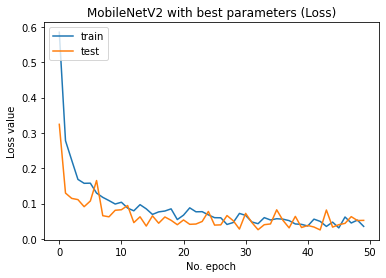

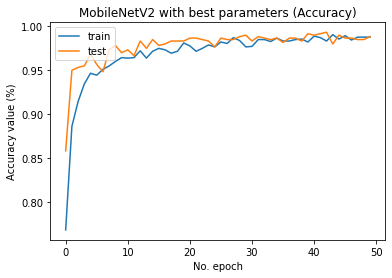

In [ ]:
plot_history(history, "MobileNetV2 with best parameters")

In [ ]:
test_generator = create_dataset(path='datasets/test')

eval_result = model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

Found 600 images belonging to 3 classes.
38/38 [==============================] - 78s 2s/step - loss: 0.0783 - accuracy: 0.9850
[test loss, test accuracy]: [0.07828312367200851, 0.9850000143051147]


#### Longer training time

In [ ]:
MODEL_FILE = "mobilenet-tuned-2.hd5"

# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
model.summary()

train_generator = create_augmented_dataset(path='datasets/train')
validation_generator = create_dataset(path='datasets/validate')

model_callbacks = [
    model_checkpoint(MODEL_FILE, monitor='val_accuracy'), 
    early_stop(patience=20, monitor='val_accuracy')
]

history = model.fit(train_generator, epochs=100, callbacks=model_callbacks, validation_data=validation_generator)

INFO:tensorflow:Reloading Oracle from existing project hyperband_search/mobilenet_transfer/oracle.json
9412608/9406464 [==============================] - 0s 0us/step
INFO:tensorflow:Reloading Tuner from hyperband_search/mobilenet_transfer/tuner0.json
hidden: 128, dropout: 0.5, learning_rate: 0.001000, optimizer: rmsprop
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               163968    
_________________________________________________________________
dro

In [ ]:
val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Best epoch: 74


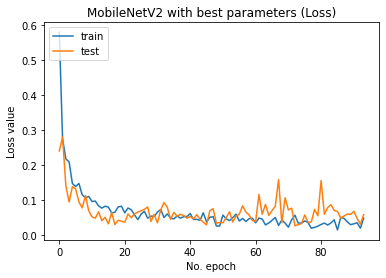

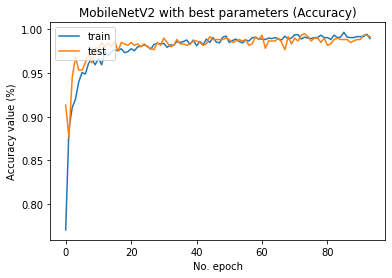

In [ ]:
plot_history(history, "MobileNetV2 with best parameters")

In [ ]:
test_generator = create_dataset(path='datasets/test')

eval_result = model.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

Found 600 images belonging to 3 classes.
38/38 [==============================] - 11s 286ms/step - loss: 0.0408 - accuracy: 0.9883
[test loss, test accuracy]: [0.040800660848617554, 0.9883333444595337]


### Testing a model

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array


def get_img_array(path):
    img = Image.open(path)
    data = img_to_array(img)
    return data


def load_images(empty_path, unlock_path, lock_pick_path):
    samples = np.array(
        [
            get_img_array(empty_path),
            get_img_array(unlock_path),
            get_img_array(lock_pick_path),
        ]
    )
    # print(samples.shape)

    datagen = ImageDataGenerator(
        # brightness_range=(0.5, 1.5),
        # rotation_range=20,
        # shear_range=0.2,
        # zoom_range=0.2,
        # horizontal_flip=True
    )

    generator = datagen.flow(samples, shuffle=False)
    return generator


def show_images(img1, img2, img3):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))
    axes[0].imshow(img1.astype("uint8"))
    axes[1].imshow(img2.astype("uint8"))
    axes[2].imshow(img3.astype("uint8"))


model_file = "mobilenet-tuned.hd5"

model_to_test = load_model(model_file)


prediction for empty: empty [1.0000000e+00 2.3783748e-14 1.5356095e-17]
prediction for lock-n-key: lock-n-key [4.257911e-14 9.999943e-01 5.683963e-06]
prediction for lock-pick: lock-pick [1.2547387e-25 2.7971000e-12 1.0000000e+00]


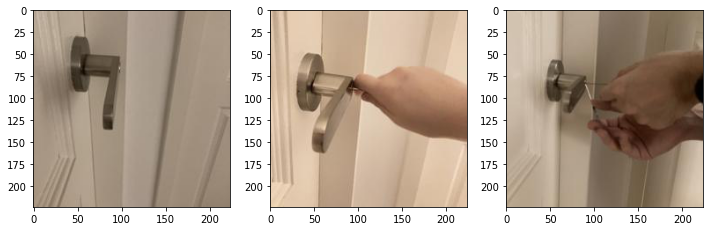

In [ ]:
empty_img = 'datasets/test/empty/IMG_7340.jpg'
unlock_img = 'datasets/train/lock-n-key/IMG_7871.jpg'
lock_pick_img = 'datasets/test/lock-pick/IMG_7790.jpg'

generator = load_images(empty_img, unlock_img, lock_pick_img)
classes = ["empty", "lock-n-key", "lock-pick"]

images = next(generator)
show_images(images[0], images[1], images[2])

results = model_to_test.predict(images / 255)
for idx, res in enumerate(results):
    class_id = np.argmax(res)
    print("prediction for %s:" % classes[idx], classes[class_id], res)

In [ ]:
test_generator = create_dataset(path='datasets/test')

eval_result = model_to_test.evaluate(test_generator)
print("[test loss, test accuracy]:", eval_result)

Found 600 images belonging to 3 classes.
38/38 [==============================] - 12s 295ms/step - loss: 0.0523 - accuracy: 0.9850
[test loss, test accuracy]: [0.05234779790043831, 0.9850000143051147]


In [ ]:
res = next(test_generator)
print(len(res), len(res[0]), len(res[0][0]), len(res[0][0][0]), len(res[0][0][0][0]))
print(res[1][:3])

model_to_test.predict(res[0][:3])

2 16 224 224 3
[[0. 1. 0.]
 [0. 0. 1.]
 [0. 0. 1.]]


array([[1.7504465e-10, 9.9969530e-01, 3.0470217e-04],
       [4.8236659e-15, 1.6467932e-06, 9.9999833e-01],
       [1.1997846e-19, 6.6319112e-12, 1.0000000e+00]], dtype=float32)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ddd5f9cd-14c1-4462-aac1-a464a84065be' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>